In [ ]:
# %pip install transformers
# %pip install pandas
# %pip install torch
# %pip install datasets

In [ ]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForMaskedLM, Trainer, TrainingArguments
import numpy as np
import re
import datasets
from datasets import Dataset
import matplotlib.pyplot as plt

In [ ]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

In [ ]:
def processCsv(file):
    texts = []
    text = ""
    line = 0
    try:
        for index,row in file.iterrows():
        #with open(os.path.join(train_dir, a_file)) as instream:
        #for line in instream:
            #text += line
            texts.append(row.loc['content'])
            line = index
    except UnicodeDecodeError:
      print(f"Unicode error for this file {file}")
    return texts, index
    

In [ ]:
file_path = '../Twitter Scraper/results/female refugee_tweet.csv'
templates = pd.read_csv(file_path, sep=",")
texts, rows = processCsv(templates.copy())

Creating hugging face dataset from text files

In [ ]:

ds_len = rows #dictionary lenght
texts_dict = {'text': [t for t in texts[:ds_len]]} #create the dictionary
ds = Dataset.from_dict(texts_dict) #dataset created by the dictionary
ds = ds.train_test_split(test_size=0.4)

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenised_ds = ds.map(lambda batch: tokenizer(batch['text']), batched=True, num_proc=2, remove_columns=['text']) #take all the text data and tokenize 

In [ ]:
block_size = 128

def group_texts(batch):
  concat_text = {k: sum(batch[k], []) for k in batch.keys()} #unpack all the items in one large list
  total_length = len(concat_text[list(batch.keys())[0]])
  total_length = (total_length // block_size) * block_size
  result = {k: [t[i: i + block_size] for i in range(0, total_length, block_size)] for k, t in concat_text.items()}
  result['labels'] = result['input_ids'].copy()
  return result

In [ ]:
blocked_ds = tokenised_ds.map(group_texts, batched=True, num_proc=2, batch_size=1000)

In [ ]:
#when we pass a token id to our model the input has to be masked (some of the token have to be replaced with a mask)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
#data_collator([blocked_ds.__getitem__(0)])
#tokenizer.convert_ids_to_tokens(50264)

Create hugging face trainer

In [ ]:
trainer_model = AutoModelForMaskedLM.from_pretrained(model_name, return_dict=True)

train_args = TrainingArguments("test-mlm",
                               disable_tqdm=False,
                               evaluation_strategy='epoch',
                               learning_rate=2e-5,
                               weight_decay=0.01,
                               num_train_epochs=3,
                               per_device_train_batch_size = 32,
                               save_steps=20000)


trainer = Trainer(model=trainer_model, args=train_args, train_dataset=blocked_ds['train'], eval_dataset=blocked_ds['test'], data_collator=data_collator)

In [61]:
trainer.train()
#trainer.evaluate()


***** Running Evaluation *****
  Num examples = 130
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.4718515872955322, 'eval_runtime': 10.535, 'eval_samples_per_second': 12.34, 'eval_steps_per_second': 1.614, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 130
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.2944998741149902, 'eval_runtime': 5.669, 'eval_samples_per_second': 22.932, 'eval_steps_per_second': 2.999, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 130
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 3.437710762023926, 'eval_runtime': 5.7208, 'eval_samples_per_second': 22.724, 'eval_steps_per_second': 2.972, 'epoch': 3.0}
{'train_runtime': 152.0262, 'train_samples_per_second': 3.927, 'train_steps_per_second': 0.138, 'train_loss': 3.586953662690662, 'epoch': 3.0}


TrainOutput(global_step=21, training_loss=3.586953662690662, metrics={'train_runtime': 152.0262, 'train_samples_per_second': 3.927, 'train_steps_per_second': 0.138, 'train_loss': 3.586953662690662, 'epoch': 3.0})

Intrasentence Evaluator

In [62]:
class IntrasentenceEvaluator():
    
    def __init__(self, data, choices, model_name, model):
        self.data = data
        self.choices = choices
        self.model = model
        self.model_name = model_name
        self.process_sentences()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        #self.model = AutoModelForMaskedLM.from_pretrained(model)
    
    #Function to make predictions and calculate how often the biased words are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        # self.bias = self.get_bias(output) #how often do we get the bias
        self.get_bias(output)

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='______'):
        candidate_sentence = []
        for index,row in self.data.iterrows():
            candidate_sentence.append([re.sub(s,row.loc[c], row.loc['sentence']) for c in self.choices.keys()]) #replace s with candidate words
        self.data.loc[:,'candidate_sentence'] = candidate_sentence
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding = [] #tokenized sentenced
        word_encoding = [] #tokenized words
        mask_idxs = [] #the indexes where the tokens of the choices are, i.e. where the <mask> should be into the candidates sentences
        for index,row in self.data.iterrows():
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,(word,sentence) in enumerate(zip(row[self.choices.keys()],row.loc['candidate_sentence'])): #for each sentences we creted in the previous function
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs
    
    #Function to make predictions:
    # We go over all sentences with help of the made encoding and see which placed words in the candidate sentences return the highest probability of being chosen.
    # We also see which words the mask filler, i.e. our model, would choose itself for the masked token.
    def make_predictions(self):
        output = [] #we want what option with highest probability has been chosen
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            # -> output shape: 3 * num of tokens*vocab size, e.g. a prediction over the vocabulary for each token in each candidate question
            # -> probability distribution over the whole vocab size
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                predictions.append(candidate_score)
            #print(f"iprediction: {q_idx}, values: {predictions}")
            output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        #print(output)
        return output
    
    #Function to see how often the biased words were chosen.
    def get_bias(self,predictions):
        biased, unbiased, unrelated = 0, 0, 0
        for pred in predictions:
            if pred == 1:
                biased +=1
            if pred == 2:
                unbiased += 1
            if pred == 3:
                unrelated += 1
        print(f"biased: {biased}")
        print(f"unbiased: {unbiased}")
        print(f"unrelated: {unrelated}")
        self.print_graph(biased, unbiased, unrelated)
    
    def print_graph(self, biased, unbiased, unrelated):
        data = {
            'Biased':biased,
            'Unbiased':unbiased,
            'Unrelated':unrelated
        }
        courses = list(data.keys())
        values = list(data.values())
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(courses, values, color ='maroon',
                width = 0.4)
        
        plt.xlabel("Choices")
        plt.ylabel("Number of sentence")
        plt.title(f"Intrasentence test - {self.model_name} (Pre-trained)")
        plt.show()
        

Run the intrasentence evaluator on the pretrain model

loading configuration file config.json from cache at /Users/mae/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/mae/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/vocab.txt
l

biased: 7
unbiased: 12
unrelated: 0


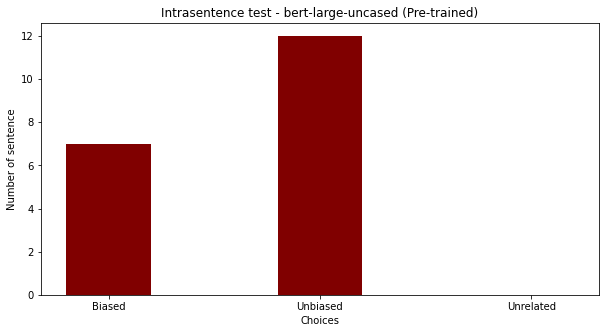

In [63]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
file_path = 'dataset/testing_data_intra.csv' #"drive/MyDrive/Final_templates.csv"#"drive/MyDrive/New_templates.csv"
model_name = 'bert-large-uncased'
templates = pd.read_csv(file_path, sep=";")
evaluator = IntrasentenceEvaluator(templates.copy(), choices, model_name, trainer.model)
evaluator.run_model_and_evaluate()